In [1]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
sys.path.append("/Users/roberto/code/corelibs/src/tools-python")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes/datatypes_python")
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *
import module
import settings

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 28})
plt.rcParams['text.usetex'] = True
plt.rc("text", usetex=True)
plt.rc("font", family='serif')
module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

from mrg.logging.monolithic_encoder import encodeForMonolithic
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python/"
                "protobuf/classification_score")
import pbClassificationScore_pb2 as pbClassificationScore_pb2

import numpy as np
from config.data import *

In [2]:
from sklearn.svm import SVC

# filename = '/Users/roberto/data/RO-logging/2019-02-06-11-52-52/tmp_combined_data.csv';
# filename = '/Users/roberto/data/RO-logging/datasets/ro-eigenvecs/maxEVecs-ro-dataset.csv';
dateAndTime = "2019-03-18-15-00-42-velCorrectorOn/";
filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
"2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"\
"motion_estimation/standard-ro/"+dateAndTime+'tmp_combined_data.csv';

print('Reading from: ' + filename)
df_combined_data = pd.read_csv(filename, names=range(2400))
df_maxEVecs = df_combined_data.iloc[:,1:] #pd.read_csv(filename, names=range(2400))

df_labels = df_combined_data.iloc[:,0:1]
labels = np.copy(df_labels.values)
labels = labels.T

[m,n] = shape(df_maxEVecs)

print("Shape of max eigenvecs is:\n",shape(df_maxEVecs))
print("Shape of labels is:\n",shape(df_labels))
print("Shape of data is:\n",shape(df_combined_data))

Reading from: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/2019-03-18-15-00-42-velCorrectorOn/tmp_combined_data.csv
Shape of max eigenvecs is:
 (5955, 2399)
Shape of labels is:
 (5955, 1)
Shape of data is:
 (5955, 2400)


1265


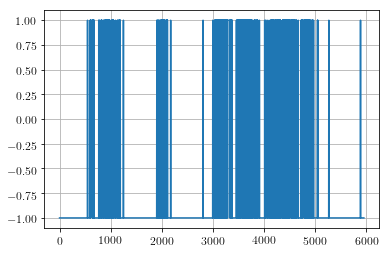

In [3]:
df_labels.head()
plt.plot(df_labels)
print(np.count_nonzero(df_labels==1))

In [4]:
eigenvectors = np.copy(df_maxEVecs.values)
max_vals = []
max_vals = eigenvectors[:,0]
num_landmarks = count_nonzero(eigenvectors,axis=1)
area_under_curve = []

for i in range(m): 
    temp_sum = 0;
    for j in range(n):
        temp_sum += eigenvectors[i,j]
    area_under_curve.append(temp_sum)
    
temp_dict = {'maxVals':max_vals,
             'numLandmarks':num_landmarks,
             'areaUnderCurve':area_under_curve}

df_features = pd.DataFrame(data = temp_dict)
print(df_features.shape)
df_features.head()

num_scans_used = 18
for i in range(1,num_scans_used):
#     print('i = ',i)
    df_features[i*3] = df_features['maxVals'].iloc[:-i]
    df_features[i*3] = df_features[i*3].shift(i)
    df_features.loc[0:i,i*3] = df_features['maxVals'].iloc[0]

    df_features[i*3+1] = df_features['numLandmarks'].iloc[:-i]
    df_features[i*3+1] = df_features[i*3+1].shift(i)
    df_features.loc[0:i,i*3+1] = df_features['numLandmarks'].iloc[0]

    df_features[i*3+2] = df_features['areaUnderCurve'].iloc[:-i]
    df_features[i*3+2] = df_features[i*3+2].shift(i)
    df_features.loc[0:i,i*3+2] = df_features['areaUnderCurve'].iloc[0]

print(df_features.shape)
df_features.head()


(5955, 3)
(5955, 54)


,maxVals,numLandmarks,areaUnderCurve,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.026703,1614,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,...,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415
1,0.026910,1604,39.792908,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,...,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415
2,0.026918,1604,39.727950,0.026910,1604.0,39.792908,0.026703,1614.0,39.880415,0.026703,...,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415
3,0.026909,1614,39.871966,0.026918,1604.0,39.727950,0.026910,1604.0,39.792908,0.026703,...,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415
4,0.026921,1612,39.847845,0.026909,1614.0,39.871966,0.026918,1604.0,39.727950,0.026910,...,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415,0.026703,1614.0,39.880415


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

maxEVecs = np.array(df_maxEVecs.values)
y_labels = ravel(labels)


print('Good RO: ',np.count_nonzero(y_labels==-1))
print('Bad RO:',np.count_nonzero(y_labels==1),'\n')

X_total = np.copy(df_features.values)
y_total = np.copy(y_labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=0)

for train_index, test_index in sss.split(X_total, y_total):
    X_train, X_test = X_total[train_index], X_total[test_index]
    y_train, y_test = y_total[train_index], y_total[test_index]
    eig_train, eig_test = maxEVecs[train_index], maxEVecs[test_index]

print('Good vs Bad RO in training: ',np.count_nonzero(y_train==-1),'good,',np.count_nonzero(y_train==1),'bad')
print('Good vs Bad RO in testing:',np.count_nonzero(y_test==-1),'good,',np.count_nonzero(y_test==1),'bad \n')

print('Good/Bad ratio in training: ',np.count_nonzero(y_train==-1)/np.count_nonzero(y_train==1))
print('Good/Bad ratio in testing:',np.count_nonzero(y_test==-1)/np.count_nonzero(y_test==1),'\n')

# print('Bad RO % in training: ',np.count_nonzero(y_train==1)/np.count_nonzero(labels==1))
# print('Bad RO % in testing:',np.count_nonzero(y_test==1)/np.count_nonzero(labels==1),'\n')

print('Bad RO % in training: ',np.count_nonzero(y_train==1)/len(y_train))
print('Bad RO % in testing:',np.count_nonzero(y_test==1)/len(y_test),'\n')

[m_train,n_train] = shape(X_train)
[m_test,n_test] = shape(X_test)
print("Size of training data is: \n",shape(X_train))
print("Size of test data is: \n",shape(X_test))

Good RO:  4690
Bad RO: 1265 

Good vs Bad RO in training:  3752 good, 1012 bad
Good vs Bad RO in testing: 938 good, 253 bad 

Good/Bad ratio in training:  3.707509881422925
Good/Bad ratio in testing: 3.707509881422925 

Bad RO % in training:  0.21242653232577666
Bad RO % in testing: 0.21242653232577666 

Size of training data is: 
 (4764, 54)
Size of test data is: 
 (1191, 54)


In [6]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
# scaler = preprocessing.MaxAbsScaler().fit(X_train)
X_scaled = preprocessing.scale(X_train)
# print("Mean: ",X_scaled.mean(axis=0))
# print("Variance: ",X_scaled.std(axis=0))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import average_precision_score

# SVM Classifier model
# clf = RandomForestClassifier(n_estimators=30,class_weight='balanced')
# clf = SVC(kernel="rbf",class_weight='balanced', C=float(20),gamma=0.1,random_state=0)
clf = SVC(kernel="linear",class_weight='balanced', C=float(1),gamma=0.001,random_state=0)
print(clf.fit(X_train, y_train))

y_predictions_X_train = clf.predict(X_train)
dec_func_X_train = clf.decision_function(X_train)

print('\nTrain metrics:')
print('Accuracy:',clf.score(X_train,y_train))
print('Precision:',precision_score(y_train,y_predictions_X_train))
print('Recall:',recall_score(y_train,y_predictions_X_train))
print('F1 score:',f1_score(y_train,y_predictions_X_train))
print('Average precision:',average_precision_score(y_train,dec_func_X_train))

y_predictions_X_test = clf.predict(X_test)
dec_func_X_test = clf.decision_function(X_test)

print('\nTest metrics:')
print('Accuracy:',clf.score(X_test,y_test))
print('Precision:',precision_score(y_test,y_predictions_X_test))
print('Recall:',recall_score(y_test,y_predictions_X_test))
print('F1 score:',f1_score(y_test,y_predictions_X_test))
print('Average precision:',average_precision_score(y_test,dec_func_X_test))

from sklearn import metrics
from sklearn.model_selection import cross_val_score
tmp_score = 'average_precision'
scores = cross_val_score(
    clf, X_train, y_train, cv=5, scoring=tmp_score)
print('\nCross validation:\n',scores)
print('Mean average precision score:',scores.mean())
print('Std dev average precision score:',scores.std())

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

Train metrics:
Accuracy: 0.8285054575986566
Precision: 0.5565873476494486
Recall: 0.9476284584980237
F1 score: 0.7012797074954296
Average precision: 0.6743454731271458

Test metrics:
Accuracy: 0.8085642317380353
Precision: 0.5275938189845475
Recall: 0.9446640316205533
F1 score: 0.6770538243626062
Average precision: 0.645282267306436

Cross validation:
 [0.68212037 0.62120992 0.67057144 0.70326673 0.65663026]
Mean average precision score: 0.6667597435111344
Std dev average precision score: 0.02742491940242124


In [8]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
tmp_score = 'average_precision'
scores = cross_val_score(
    clf, X_train, y_train, cv=5, scoring=tmp_score)
print(scores)
print('Mean average precision score:',scores.mean())
print('Std dev average precision score:',scores.std())

[0.68212037 0.62120992 0.67057144 0.70326673 0.65663026]
Mean average precision score: 0.6667597435111344
Std dev average precision score: 0.02742491940242124


Area under PR curve: 0.6737385073659069
Average precision score: 0.6741146564529955


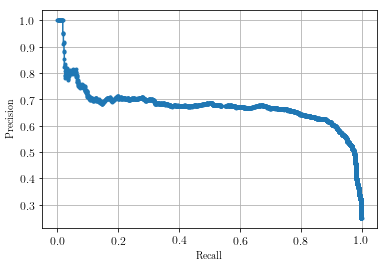

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
clf_probs = SVC(kernel="linear",class_weight='balanced', C=float(0.1),gamma=0.001,random_state=0,probability=True)
clf_probs.fit(X_train,y_train)
probs = clf_probs.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, probs)
print('Area under PR curve:',auc(recall,precision))
print('Average precision score:',average_precision_score(y_train, probs))
# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [29]:
# import eigenvectors from REAL test set (not the 0.2 validation set)
test_file = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
"2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"\
"motion_estimation/untuned-kalman-with-chi-all-good-labels/2019-04-10-14-49-14/MaxEVec.csv"
print('Reading from: ' + test_file)
df_combined_test = pd.read_csv(test_file, names=range(2400))
df_maxEVecs_test = df_combined_test.iloc[:,1:] #pd.read_csv(filename, names=range(2400))

df_test_timestamps = df_combined_test.iloc[:,0:1]
test_timestamps = np.copy(df_test_timestamps.values)
test_timestamps = test_timestamps.T

where_are_NaNs = isnan(df_maxEVecs_test)
df_maxEVecs_test[where_are_NaNs] = 0.0

max_evec_test = np.copy(df_maxEVecs_test.iloc[:,1:2400].values)
sorted_max_evecs_test = max_evec_test
for i in range(len(max_evec_test)): # to sort all of them
    sorted_max_evecs_test[i] = sort(max_evec_test[i])[::-1]

print("Shape of test eigenvector data is:\n",shape(df_maxEVecs_test))
# df_maxEVecs_test.head()

# Handcrafted features for test dataset
eigenvectors = np.copy(df_maxEVecs_test.values)
max_vals = []
max_vals = eigenvectors[:,0]
num_landmarks = count_nonzero(eigenvectors,axis=1)
area_under_curve = []

for i in range(len(df_maxEVecs_test)): 
    temp_sum = 0;
    for j in range(n):
        temp_sum += eigenvectors[i,j]
    area_under_curve.append(temp_sum)
    
temp_dict = {'maxVals':max_vals,
             'numLandmarks':num_landmarks,
             'areaUnderCurve':area_under_curve}

df_features_test = pd.DataFrame(data = temp_dict)
print(df_features_test.shape)
# df_features_test.head()

for i in range(1,num_scans_used):
    df_features_test[i*3] = df_features_test['maxVals'].iloc[:-i]
    df_features_test[i*3] = df_features_test[i*3].shift(i)
    df_features_test.loc[0:i,i*3] = df_features_test['maxVals'].iloc[0]

    df_features_test[i*3+1] = df_features_test['numLandmarks'].iloc[:-i]
    df_features_test[i*3+1] = df_features_test[i*3+1].shift(i)
    df_features_test.loc[0:i,i*3+1] = df_features_test['numLandmarks'].iloc[0]

    df_features_test[i*3+2] = df_features_test['areaUnderCurve'].iloc[:-i]
    df_features_test[i*3+2] = df_features_test[i*3+2].shift(i)
    df_features_test.loc[0:i,i*3+2] = df_features_test['areaUnderCurve'].iloc[0]

print(df_features_test.shape)
df_features_test.head()

# preprocess actual test data from another run (KFC)
X_test_set = np.copy(df_features_test.values)
X_test_set = preprocessing.scale(X_test_set) #should be the same as scaler.transform

Reading from: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/untuned-kalman-with-chi-all-good-labels/2019-04-10-14-49-14/MaxEVec.csv
Shape of test eigenvector data is:
 (5955, 2399)
(5955, 3)
(5955, 54)


GT failures: 903
Less strict predicted failures: 215


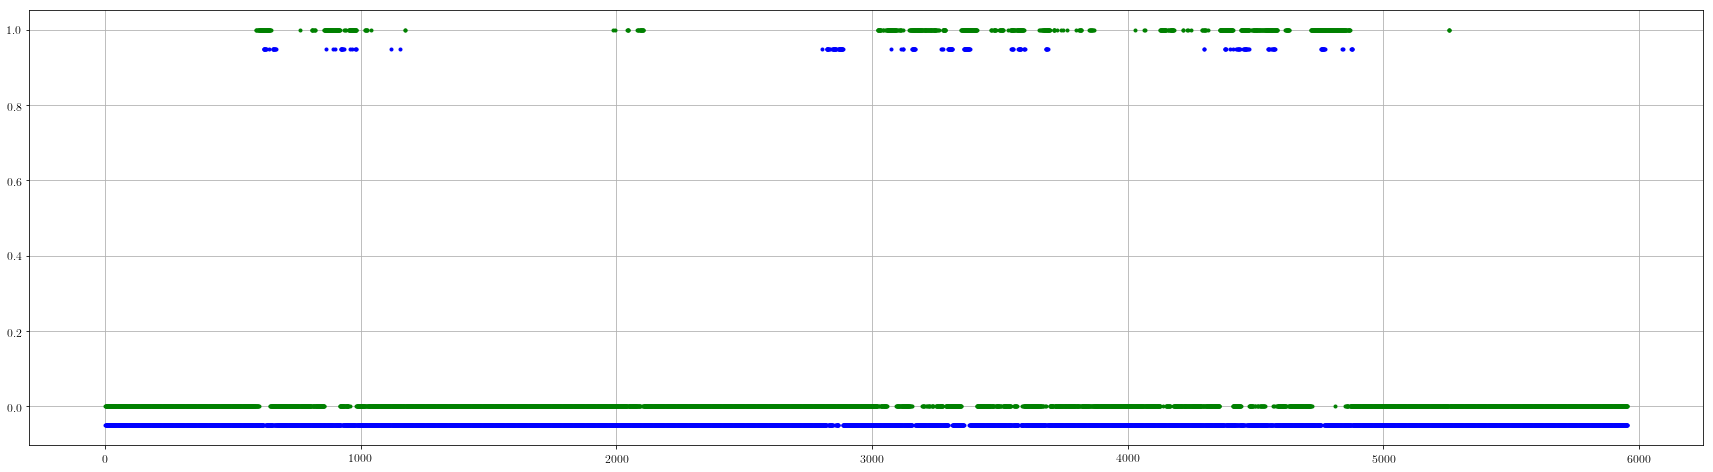

importing  protobuf.logging.pbMonolithicIndexArray_pb2
importing  protobuf.classification_score.pbClassificationScore_pb2
Finished importing ground truth labels.
Size of imported labels is: 5955
Number of classified failures in this monolithic: 903


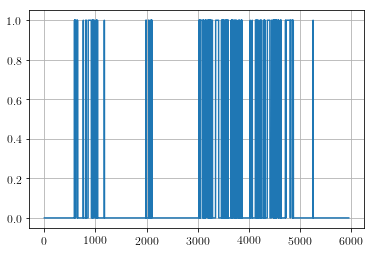

In [28]:
import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
sys.path.append("/Users/roberto/code/corelibs/src/tools-python")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes/datatypes_python")
import module

from mrg.logging import MonolithicDecoder
from mrg.logging import IndexedMonolithic

from protobuf.classification_score import pbClassificationScore_pb2
# classification_file = "/Users/roberto/data/odometry-comparisons/"\
# "rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"\
# "motion_estimation/ground-truth/labels.monolithic"
# classification_file="/Users/roberto/data/odometry-comparisons/rugged_ro/allGoodLabels.monolithic"
classification_file="/Users/roberto/data/odometry-comparisons/rugged_ro/training_gt_labels_KFC.monolithic"

mono_decoder = IndexedMonolithic(classification_file) #MonolithicDecoder(classification_file)
classification_scores = []
classification_timestamps = []

for pb, _, _ in mono_decoder:
    timestamp = pb.timestamp
    classification_score = pb.score
    classification_scores.append(classification_score)
    classification_timestamps.append(timestamp)
print("Finished importing ground truth labels.")
print("Size of imported labels is:",len(classification_scores))
print('Number of classified failures in this monolithic:',count_nonzero(np.array(classification_scores, np.int32)==1.0))

import matplotlib.pyplot as plt
plt.plot(classification_scores)
plt.show()

GT failures: 903
Less strict predicted failures: 496


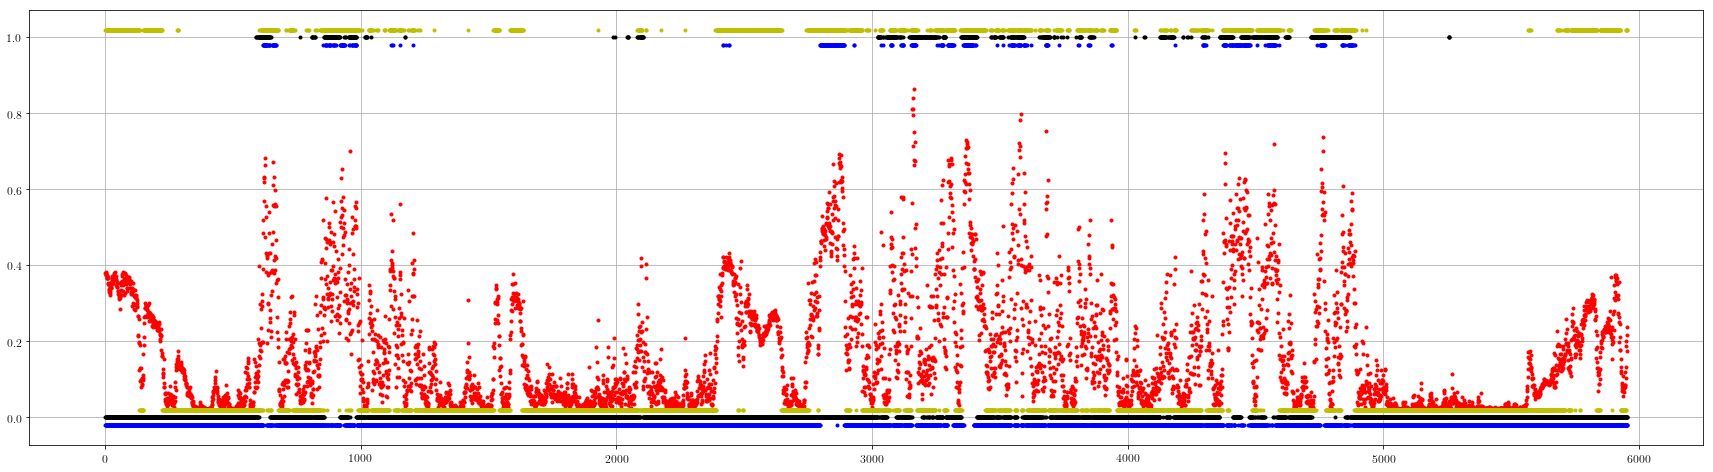

In [43]:
# X_experiment = np.copy(df_features.values)
# X_experiment = preprocessing.scale(X_experiment)
# tmp = clf.predict(X_experiment)


# clf_probs = SVC(kernel="linear",class_weight='balanced', C=float(0.1),gamma=0.001,random_state=0,probability=True)
# clf_probs.fit(X_train,y_train)
standard_labels = clf.predict(X_test_set)
standard_labels[standard_labels==-1] = 0
probs = clf_probs.predict_proba(X_test_set)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
tmp = probs
y_train_pred_thresholding = (probs > 0.4)
# tmp[tmp==-1]=0
plt.figure(figsize=(30,8))
plt.plot([x+0.02 for x in tmp],'r.')
plt.plot([x+0.02 for x in standard_labels],'y.')
plt.plot(classification_scores,'k.')
plt.plot([x-0.02 for x in y_train_pred_thresholding],'b.')
print('GT failures:',count_nonzero(classification_scores))
# print('Predicted failures:',count_nonzero(tmp))
print('Less strict predicted failures:',count_nonzero(y_train_pred_thresholding))

Failures predicted by classifier: 496


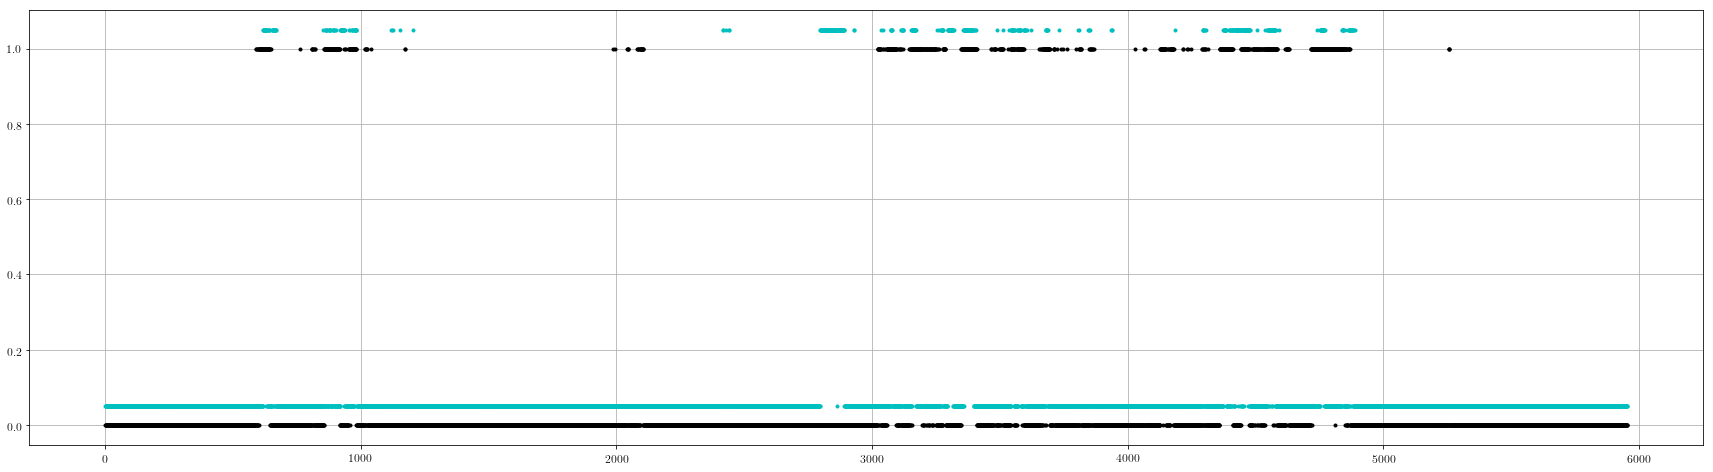

In [57]:
# Adjust labels for test dataset
X_test_set = preprocessing.scale(X_test_set)
probs = clf_probs.predict_proba(X_test_set)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

y_train_pred_thresholding = (probs > 0.4)
test_labels = np.array(y_train_pred_thresholding, np.int32)
# plt.plot(test_labels)
# test_labels[test_labels==True] = 1
# test_labels[test_labels==0] = -1
plt.figure(figsize=(30,8))
plt.plot([x+0.05 for x in test_labels],'c.')
plt.plot(classification_scores,'k.')
print('Failures predicted by classifier:',count_nonzero(test_labels==1))

writing to labels monolithic: /Users/roberto/data/odometry-comparisons/rugged_ro/15-58_generated_SVM_labels_KFC.monolithic...
Finished.
Size of labels in monolithic is: 5954


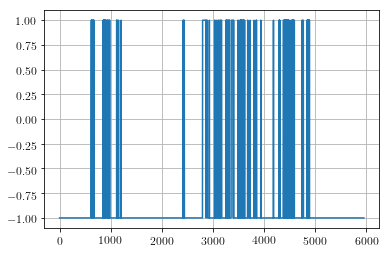

In [50]:
# Make predictions on unseen dataset
# test_labels = clf.predict(X_test_set)
# account for startup time
# test_labels[0:200] = -1
plt.plot(test_labels)
# plt.plot(X_test_set);

test_timestamps = test_timestamps.T

write_mono_labels = True
start = 0
finish = len(test_timestamps)-1
if(write_mono_labels == True):
    labels_filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/15-58_generated_SVM_labels_KFC.monolithic"
    print("writing to labels monolithic: " + labels_filename + "...")
    with open(labels_filename, 'wb') as file_handle:
        for i in range(start,finish):
            pb_classification_score = pbClassificationScore_pb2.pbClassificationScore()
            pb_classification_score.timestamp = test_timestamps[i] 
            if(test_labels[i] == -1):
                # Good match
                pb_classification_score.score = 0 
            else:
                # Bad match
                pb_classification_score.score = 1
            file_handle.write(
                encodeForMonolithic(
                    pb_classification_score,
                    'radarutilities.datatypes.protobuf.classification_score.pbClassificationScore') +
                b"\n")
    print("Finished.")
    print("Size of labels in monolithic is:",finish-start)